In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, FormatStrFormatter, MultipleLocator
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import os
from cmcrameri import cm

In [2]:
import utils.load_grid as lg
from proteus.config import read_config
from proteus.utils.constants import M_earth, M_jupiter, R_earth, R_jupiter

In [3]:
fwl_dir = os.environ.get("FWL_DATA")

In [4]:
def _get_exo_data():
    popfile = os.path.join(fwl_dir, "planet_reference", "Exoplanets", "DACE_PlanetS.csv")
    return pd.read_csv(popfile,comment="#")

def _get_mr_data():
    z19 = os.path.join(fwl_dir, "mass_radius", "Mass-radius", "Zeng2019")

    # Set paths
    curves = {
        "Earth-like":           os.path.join(z19, "massradiusEarthlikeRocky.txt"),
        r"MgSiO$_3$":           os.path.join(z19, "massradiusmgsio3.txt"),
        r"100% H$_2$O (700 K)": os.path.join(z19, "massradius_100percentH2O_700K_1mbar.txt"),
        r"5% H$_2$ (700 K)":    os.path.join(z19, "Earthlike5h700K1mbar.txt"),
        r"2% H$_2$ (700 K)":    os.path.join(z19, "Earthlike2h700K1mbar.txt"),
        r"1% H$_2$ (700 K)":    os.path.join(z19, "Earthlike1h700K1mbar.txt"),
        r"Cold H$_2$":          os.path.join(z19, "massradiushydrogen.txt"),
    }

    # Replace paths with the data
    for k in curves.keys():
        data = np.loadtxt(curves[k]).T
        mask = np.argsort(data[0])
        curves[k] = [data[0][mask],data[1][mask]]

    return curves

# Get exoplanet values from database
exo = _get_exo_data()
# exo = exo.loc[exo["Planet Mass [Mjup]"] * M_jupiter / M_earth <= m_max*1.1]

exo_mas_val = exo["Planet Mass [Mjup]"]             * M_jupiter / M_earth
exo_mas_upp = exo["Planet Mass - Upper Unc [Mjup]"] * M_jupiter / M_earth
exo_mas_low = exo["Planet Mass - Lower Unc [Mjup]"] * M_jupiter / M_earth

exo_rad_val = exo["Planet Radius [Rjup]"]             * R_jupiter / R_earth
exo_rad_upp = exo["Planet Radius - Upper Unc [Rjup]"] * R_jupiter / R_earth
exo_rad_low = exo["Planet Radius - Lower Unc [Rjup]"] * R_jupiter / R_earth

exo_age_val = np.array(exo["Stellar Age [Gyr]"]   )  * 1e9    # yr
exo_rho_val = np.array(exo["Planet Density [g/cm**3] - Computation"]) # g cm-3

# Get Mass-Radius curves from files
mrdata = _get_mr_data()

In [5]:
t0 = 1e2
m_max = 5
m_min = 0.1

In [6]:
pgrid_dir = "data/output/l98d_escape7/"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

cnums = ["%d"%int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

confs = []
for f in cases:
    confs.append( read_config(f+"/init_coupler.toml") )

# transit, eclipse = lg.load_synthobs(cases)

print("Done")

Helpfiles:  29%|██▊       | 6/21 [00:00<00:01, 12.84it/s]

Helpfiles: 100%|██████████| 21/21 [00:01<00:00, 11.35it/s]


Done


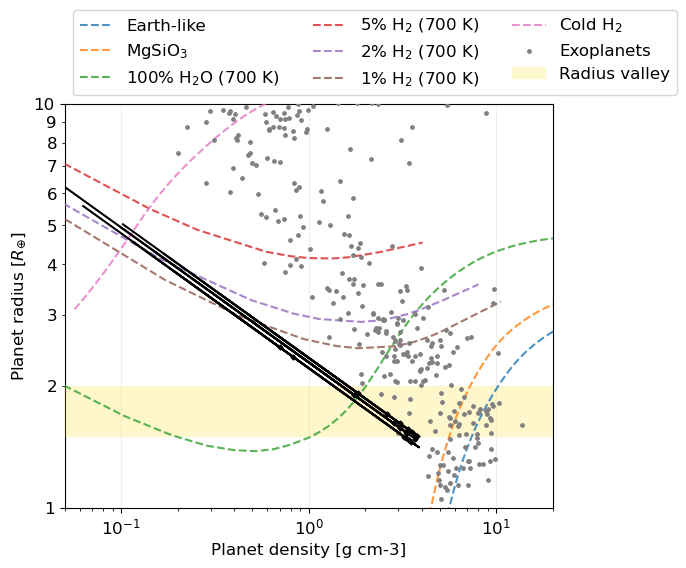

In [7]:
# Create plot
scale = 1.05
fig,ax = plt.subplots(1,1,figsize=(6*scale,5*scale))

# M-R curves
for k in mrdata.keys():
    m = mrdata[k][0] * M_earth
    r = mrdata[k][1] * R_earth
    rho = 3*m/(4*np.pi*r**3)  * 0.001
    ax.plot(rho,r/R_earth, label=k, linestyle='dashed', alpha=0.8, zorder=9)

# Exoplanets
lbl = "Exoplanets"
col = 'grey'
ms=6
ax.scatter(exo_rho_val, exo_rad_val, color=col, label=lbl, s=ms, zorder=10)

# Simulation
xmin = 0.5
xmax = 20.0
ymin = 1.0
ymax = 10.0
for i in range(ncases):
    hf_all = helps[i]
    hf_crop = hf_all.loc[hf_all["Time"]>t0]
    time = np.array(hf_crop["Time"])

    sim_tmp = np.array(hf_crop["T_surf"])
    sim_rad = np.array(hf_crop["R_obs"])
    sim_mas = np.array(hf_crop["M_planet"])
    sim_rho = 3*sim_mas/(4*np.pi*sim_rad**3)  * 0.001

    sim_rad /= R_earth
    sim_mas /= M_earth

    col='k'
    x = sim_rho
    y = sim_rad

    ax.plot(x, y, color=col, lw=1.5, zorder=12)
    ax.scatter(x[-1], y[-1], color=col, s=ms, zorder=12, marker='D')

    xmax = max(xmax, np.amax(x))
    xmin = min(xmin, np.amin(x))
    ymax = max(ymax, np.amax(y))
    ymin = min(ymin, np.amin(y))

# Radius valley
ax.fill_between([xmin,xmax], 1.5, 2.0, zorder=8,alpha=0.2, color='gold', ec='none', label="Radius valley")

# Save figure
ax.set_ylabel(r"Planet radius [$R_{\oplus}$]")
ax.set_yscale("log")
ax.set_ylim(ymin, ymax)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.0f"))

ax.set_xlabel(r"Planet density [g cm-3]")
ax.set_xscale("log")
ax.set_xlim(xmin, xmax)

ax.grid(alpha=0.2, zorder=-2)
ax.legend(ncols=3, loc='lower left', bbox_to_anchor=(0,1))
plt.show()

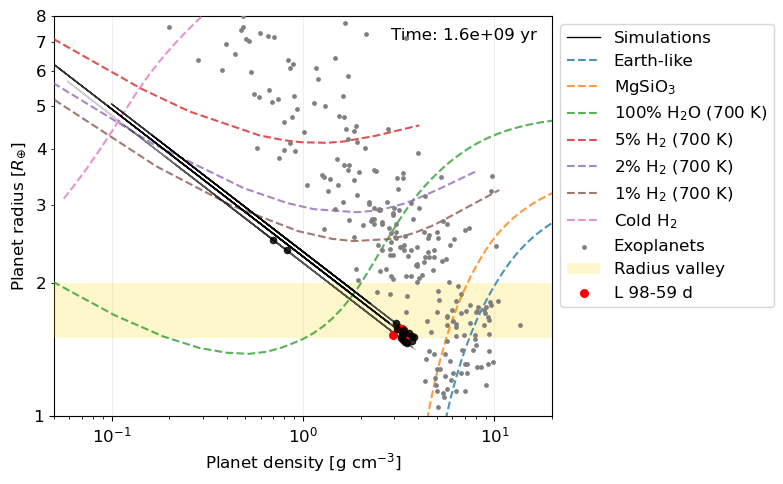

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

xmin, xmax = 0.05, 20
ymin, ymax = 1.0, 8

ax.set_ylabel(r"Planet radius [$R_{\oplus}$]")
ax.set_yscale("log")
ax.set_ylim(ymin, ymax)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.0f"))

ax.set_xlabel(r"Planet density [g cm$^{-3}$]")
ax.set_xscale("log")
ax.set_xlim(xmin, xmax)

lines = []

# Create lines for simulations
for i in range(ncases):
    x,y = [], []
    if i == 0:
        lbl = "Simulations"
    else:
        lbl = ""
    l = ax.plot(x, y, color='k', lw=1, zorder=12, label=lbl)[0]
    lines.append(l)

# Create endpoints
for i in range(ncases):
    x,y = [],[]
    l = ax.scatter(x, y, color='k', s=20, zorder=13)
    lines.append(l)

# Time
l = ax.text(0.97, 0.97, "Time: [unset]", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
lines.append(l)
itext = len(lines)-1

# M-R curves
for k in mrdata.keys():
    m = mrdata[k][0] * M_earth
    r = mrdata[k][1] * R_earth
    rho = 3*m/(4*np.pi*r**3)  * 0.001
    l = ax.plot(rho,r/R_earth, label=k, linestyle='dashed', alpha=0.8, zorder=9)[0]
    lines.append(l)

# Exoplanets
lbl = "Exoplanets"
col = 'grey'
ms=6
l = ax.scatter(exo_rho_val, exo_rad_val, color=col, label=lbl, s=ms, zorder=10)
lines.append(l)

# Radius valley
l = ax.fill_between([xmin,xmax], 1.5, 2.0, zorder=8,alpha=0.2, color='gold', ec='none', label="Radius valley")
lines.append(l)

# Observations
lines.append(ax.scatter(2.95,1.52, s=30, zorder=11, color='red', label="L 98-59 d"))
lines.append(ax.scatter(3.45,1.52, s=30, zorder=11, color='red'))
lines.append(ax.scatter(3.17,1.58, s=30, zorder=11, color='red'))
lines.append(ax.scatter(3.30,1.57, s=30, zorder=11, color='red'))

# Decorate
ax.grid(alpha=0.2, zorder=-2)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
fig.tight_layout()

def update(t):

    # for each case
    for i in range(ncases):
        hf_all = helps[i]

        # get index of closest time
        idx_close = np.argmin(np.abs(t - hf_all["Time"]))
        hf_crop = hf_all.iloc[range(idx_close)]

        col = 'k'

        # get data
        time = np.array(hf_crop["Time"])
        sim_tmp = np.array(hf_crop["T_surf"])
        sim_rad = np.array(hf_crop["R_obs"])
        sim_mas = np.array(hf_crop["M_planet"])
        sim_rho = 3*sim_mas/(4*np.pi*sim_rad**3)  * 0.001

        sim_rad /= R_earth
        sim_mas /= M_earth

        x = sim_rho
        y = sim_rad

        iline = i
        iscat = i + ncases

        lines[iline].set_data(x, y)
        lines[iscat].set_offsets([x[-1],y[-1]])

        # is this the last sample?
        if idx_close >= len(hf_all)-2:
            lines[iscat].set_alpha(0.8)
            lines[iline].set_alpha(0.2)
            lines[iline].set_zorder(11)
        else:
            lines[iscat].set_alpha(0.0)
            lines[iline].set_alpha(0.8)
            lines[iline].set_zorder(12)

    lines[itext].set_text("Time: %.1e yr"%t)

    return lines

duration = 10.0
time_arr = np.logspace(3, 9.2, 10)
ani = FuncAnimation(fig, update, frames=time_arr, blit=True, interval=duration/len(time_arr)*1e3)
ani.save(filename="output/animate.mp4", writer="ffmpeg")
HTML(ani.to_jshtml())